# COMP4211-Tutorial 8: Policy Iteration and Value Iteration
**Weiyu CHEN, wchenbx@connect.ust.hk**

OpenAI Gym is a cool python package that provides ready-to-use environments to test RL algorithms on. As a python package, it is easy to install:

In [1]:
pip install gym==0.17.3

Note: you may need to restart the kernel to use updated packages.


## Environment
Let's start with a simple example introduced in the lecture. You are an agent on an MxN grid and your goal is to reach the terminal state at the top left or the bottom right corner. You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3). Actions going off the edge leave you in your current state. You receive a reward of -1 at each step until you reach a terminal state.

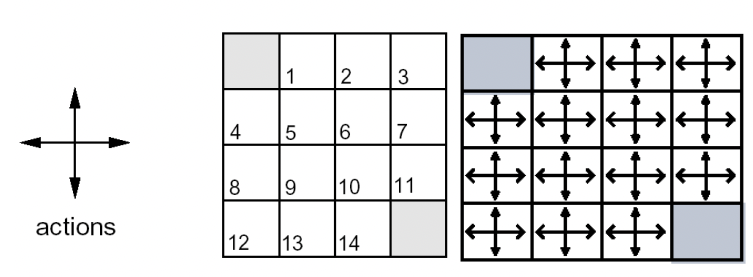

In [2]:
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)


## Policy Evaluation

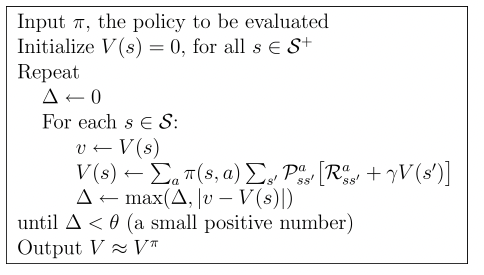

In [3]:
env = GridworldEnv()
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value. 
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [4]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)
print(v)

[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569
   0.        ]


In [5]:
# Test: Make sure the evaluated policy is what we expected
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

## Policy Iteration
Policy iteration iterates through policies until it converges on the optimal policy.

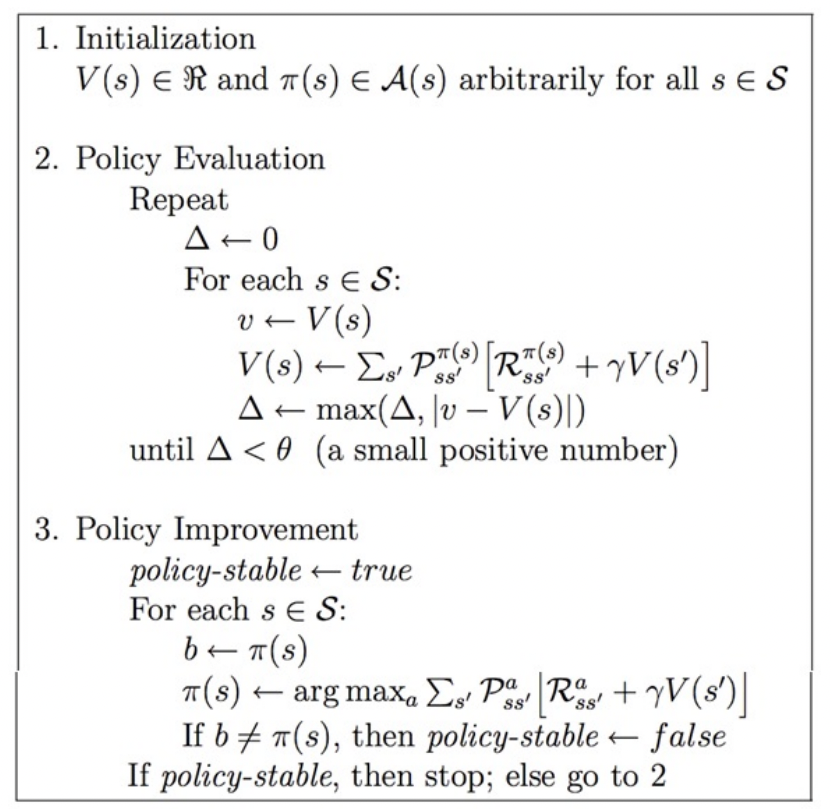

In [6]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    iteration = 0
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        
        print(f"[Iteration {iteration}]")
        print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
        print(np.reshape(np.argmax(policy, axis=1), env.shape))
        print("Reshaped Grid Value Function:")
        print(V.reshape(env.shape))
        print("")
        iteration += 1
        
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [7]:
env = GridworldEnv()
policy, V = policy_improvement(env)

[Iteration 0]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[  0.         -13.99993529 -19.99990698 -21.99989761]
 [-13.99993529 -17.9999206  -19.99991379 -19.99991477]
 [-19.99990698 -19.99991379 -17.99992725 -13.99994569]
 [-21.99989761 -19.99991477 -13.99994569   0.        ]]

[Iteration 1]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

[Iteration 2]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [8]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(V, expected_v, decimal=2)

## Value Iteration

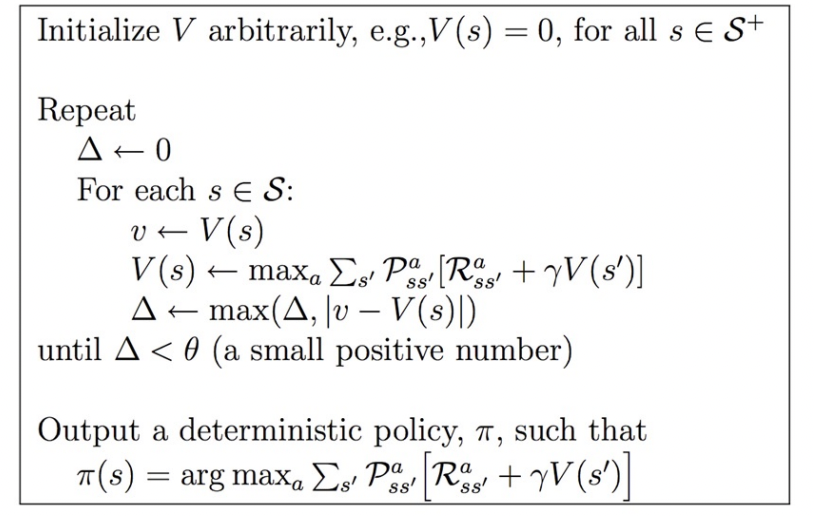

In [9]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    iteration = 0
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. 
            V[s] = best_action_value  
        
        # Create a deterministic policy using the optimal value function
        policy = np.zeros([env.nS, env.nA])
        for s in range(env.nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s, best_action] = 1.0
        
        print(f"[Iteration {iteration}]")
        print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
        print(np.reshape(np.argmax(policy, axis=1), env.shape))
        print("Reshaped Grid Value Function:")
        print(V.reshape(env.shape))
        print("")
        iteration += 1
        # Check if we can stop 
        if delta < theta:
            break
    
    return policy, V

In [10]:
env = GridworldEnv()
policy, V = value_iteration(env)

[Iteration 0]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

[Iteration 1]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 0]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -2. -2.]
 [-1. -2. -2. -2.]
 [-2. -2. -2. -1.]
 [-2. -2. -1.  0.]]

[Iteration 2]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

[Iteration 3]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [11]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(V, expected_v, decimal=2)

Reference: https://github.com/dennybritz/reinforcement-learning